<a href="https://colab.research.google.com/github/MagMueller/Solar-Potential-Analysis-using-Semi-Supervised-Image-Segmentation/blob/main/Semi-Supervised-Image-Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train on a custom solar dataset

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">



# Install detectron2 and import libaries

In [ ]:
#!pip install -U torch torchvision
#!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

'1.10.0+cu111'

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.engine import DefaultTrainer

import os

# Load and visualize

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.



Register the solar dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [ ]:
import json

In [ ]:
catalog_name = "obstacles2"
catalog_name_test = catalog_name + "_test"
path = 'drive/MyDrive/developer/Sofie/'

In [ ]:
catalog_name_test = catalog_name + "_test2"

In [ ]:
anno = open(path + "annotations.json")
data = json.load(anno)


In [ ]:

from detectron2.data.datasets import register_coco_instances
register_coco_instances(catalog_name, {}, path + "annotations.json", path + "data/")


In [ ]:

# register test data
# be carful, test and train images are identical!!!, because annotation is needed. We testet the output on real new images in the end of the notebook
register_coco_instances(catalog_name_test, {}, path + "annotations.json", path + "data/")


In [ ]:
solar_houses_metadata = MetadataCatalog.get(catalog_name)
dataset_dicts = DatasetCatalog.get(catalog_name)

[04/03 08:05:32 d2.data.datasets.coco]: Loaded 14 images in COCO format from drive/MyDrive/developer/Sofie/annotations.json


In [ ]:
# be carful, test and train images are identical!!!, because annotation is needed. We testet the output on real new images in the end of the notebook
solar_houses_metadata_test = MetadataCatalog.get(catalog_name_test)
dataset_dicts_test = DatasetCatalog.get(catalog_name_test)

[04/03 08:05:32 d2.data.datasets.coco]: Loaded 14 images in COCO format from drive/MyDrive/developer/Sofie/annotations.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [ ]:
import os


count = 1
# count increase by 1 in each iteration
# iterate all files from a directory
folder = path + 'data/'
for file_name in os.listdir(folder):
    if '.png' not in file_name:
      continue
      
    # Construct old file name
    source = folder + file_name

    # Adding the count to the new file name and extension
    destination = folder + file_name.split(".")[0] + ".PNG"

    # Renaming the file
    os.rename(source, destination)
    count += 1
print('All Files Renamed')

print('New Names are')
# verify the result
res = os.listdir(folder)
print(res)

All Files Renamed
New Names are
['05ab6d16-e84a-4836-9e9d-adce34b2877e.out', '005f5844-dbda-46cd-ba41-27f5ee16a118.out', '0925c965-f60f-4901-8ee1-2932f56c197b.out', '0076329b-d178-47ab-bff3-65054b254751.out', '096c1f59-22e6-44f4-80d7-0b2d9d496d05.out', '06f263d9-d41c-4826-bcea-d3f5bbb50ddb.out', '0aa574d1-176a-4941-9a33-18dd7a5904b6.out', '088bfdc3-c2d4-4a45-b94e-98fb8ac662cd.out', '0812bab5-4bdf-420d-9dc9-62b481b6a452.out', '0b5f3248-cc7c-4999-8453-e6e7072287a6.out', '00477b5b-d6c4-4a8b-9654-dcb771ed5cec.out', '04bd5629-2d23-4250-92d9-2fae848d55cd.out', '0d4663b9-fb5f-45b1-b7b8-50486e42b128.out', '0b0816b0-f1ad-4e65-b17a-df95d93c8a7b.out', '06f263d9-d41c-4826-bcea-d3f5bbb50ddb.PNG', '00477b5b-d6c4-4a8b-9654-dcb771ed5cec.PNG', '05ab6d16-e84a-4836-9e9d-adce34b2877e.PNG', '096c1f59-22e6-44f4-80d7-0b2d9d496d05.PNG', '088bfdc3-c2d4-4a45-b94e-98fb8ac662cd.PNG', '0b0816b0-f1ad-4e65-b17a-df95d93c8a7b.PNG', '0925c965-f60f-4901-8ee1-2932f56c197b.PNG', '005f5844-dbda-46cd-ba41-27f5ee16a118.PNG',

{'file_name': 'drive/MyDrive/developer/Sofie/data/0b5f3248-cc7c-4999-8453-e6e7072287a6.PNG', 'height': 256, 'width': 256, 'image_id': 100, 'annotations': [{'iscrowd': False, 'bbox': [19, 160, 82, 88], 'category_id': 0, 'segmentation': [[80.1, 159.6, 101.5, 186.2, 27.9, 248.7, 18, 238, 69, 195.6, 56.6, 180.6]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': False, 'bbox': [7, 184, 55, 51], 'category_id': 0, 'segmentation': [[51, 183.8, 62.1, 197.3, 17.6, 235.4, 6.7, 221.5]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': False, 'bbox': [26, 149, 16, 16], 'category_id': 1, 'segmentation': [[41.7, 157.5, 32.7, 165.2, 26.1, 157.3, 35.9, 148.1]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': False, 'bbox': [6, 172, 11, 12], 'category_id': 1, 'segmentation': [[17, 178.1, 10.6, 183.9, 5.5, 178.4, 11.5, 172.1]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': False, 'bbox': [43, 173, 12, 13], 'category_id': 3, 'segmentation': [[55.5, 178.7, 47.8, 186.1, 42.1, 181.2, 49.6, 172.9]], 'bbo

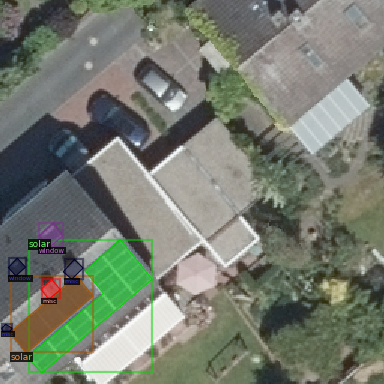

{'file_name': 'drive/MyDrive/developer/Sofie/data/05ab6d16-e84a-4836-9e9d-adce34b2877e.PNG', 'height': 256, 'width': 256, 'image_id': 44, 'annotations': [{'iscrowd': False, 'bbox': [209, 129, 18, 17], 'category_id': 1, 'segmentation': [[226.5, 139.5, 215.6, 146.3, 208.3, 136.9, 217.7, 129.2]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': False, 'bbox': [144, 174, 21, 20], 'category_id': 1, 'segmentation': [[165.7, 184.9, 152.2, 194.3, 144, 183.8, 156, 173.8]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': False, 'bbox': [176, 85, 18, 18], 'category_id': 1, 'segmentation': [[194.1, 94.5, 183.1, 103.6, 175.1, 94.2, 185.2, 84.7]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': False, 'bbox': [138, 35, 21, 19], 'category_id': 1, 'segmentation': [[159.3, 45.7, 145.9, 54.1, 138.1, 44.3, 150.7, 34.5]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': False, 'bbox': [189, 75, 16, 17], 'category_id': 3, 'segmentation': [[205.8, 83.2, 195, 92.1, 188.2, 84.1, 198.5, 74.6]], 'bbox_mode': 

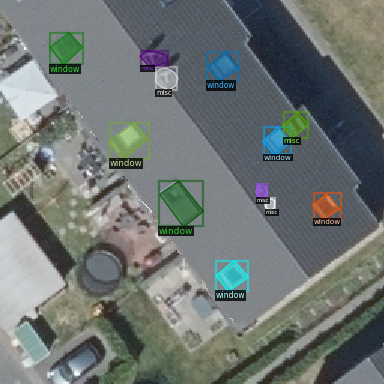

{'file_name': 'drive/MyDrive/developer/Sofie/data/0aa574d1-176a-4941-9a33-18dd7a5904b6.PNG', 'height': 256, 'width': 256, 'image_id': 92, 'annotations': [{'iscrowd': False, 'bbox': [127, 89, 44, 48], 'category_id': 0, 'segmentation': [[161.6, 137, 157.6, 125.2, 147.5, 128.6, 144.5, 119, 134.2, 122.4, 126.9, 99.7, 155, 88.6, 171.5, 134.2]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': False, 'bbox': [114, 101, 18, 26], 'category_id': 0, 'segmentation': [[124.2, 101, 132.1, 123.7, 121.8, 127.1, 113.7, 103.8]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': False, 'bbox': [84, 106, 35, 54], 'category_id': 0, 'segmentation': [[111.1, 105.7, 119, 128.4, 110.2, 131.2, 114.3, 143.2, 105.5, 146, 110.5, 157.1, 100, 160.3, 83.7, 116]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': False, 'bbox': [109, 127, 53, 40], 'category_id': 2, 'segmentation': [[154.3, 130.5, 161.6, 148.5, 115, 167.2, 109.4, 149.6, 127.2, 126.5]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': False, 'bbox': [47,

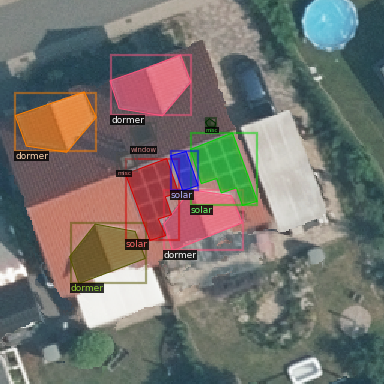

In [ ]:
import random

for d in random.sample(dataset_dicts, 3):
    print(d)
    img_path = d["file_name"]#.replace('MSHACK_SoFiE_data/data/','MSHACK_SoFiE_data/data/MM/')
    img = cv2.imread(img_path)
    #print(path, img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=solar_houses_metadata, scale=1.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Training

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
CUDA_LAUNCH_BLOCKING = 1

In [ ]:


cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = (catalog_name,)
cfg.DATASETS.TEST = (catalog_name_test,)   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02 
cfg.SOLVER.MAX_ITER = 200    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 1 classes (solar)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/02 16:38:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

[04/02 16:38:35 d2.engine.train_loop]: Starting training from iteration 0
[04/02 16:38:57 d2.utils.events]:  eta: 0:03:19  iter: 19  total_loss: 2.64  loss_cls: 0.9196  loss_box_reg: 0.7342  loss_mask: 0.6509  loss_rpn_cls: 0.2012  loss_rpn_loc: 0.1303  time: 1.0842  data_time: 0.0196  lr: 0.0019181  max_mem: 2538M
[04/02 16:39:18 d2.utils.events]:  eta: 0:02:58  iter: 39  total_loss: 1.978  loss_cls: 0.5903  loss_box_reg: 0.7893  loss_mask: 0.3918  loss_rpn_cls: 0.07311  loss_rpn_loc: 0.1193  time: 1.0763  data_time: 0.0108  lr: 0.0039161  max_mem: 2539M
[04/02 16:39:40 d2.utils.events]:  eta: 0:02:35  iter: 59  total_loss: 1.478  loss_cls: 0.4201  loss_box_reg: 0.6085  loss_mask: 0.2878  loss_rpn_cls: 0.03217  loss_rpn_loc: 0.1192  time: 1.0820  data_time: 0.0088  lr: 0.0059141  max_mem: 2539M
[04/02 16:40:02 d2.utils.events]:  eta: 0:02:13  iter: 79  total_loss: 1.244  loss_cls: 0.3141  loss_box_reg: 0.5704  loss_mask: 0.2539  loss_rpn_cls: 0.0272  loss_rpn_loc: 0.1082  time: 1.0887

# Ploting the output of our model on train images

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



Be carful, test and train images are identical!!!, because annotation is needed. We testet the output on real new images in the end of the notebook

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = (catalog_name_test, )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
dataset_dicts_test_only_solar = []
for img in dataset_dicts_test:
  if img['annotations']:
    dataset_dicts_test_only_solar.append(img)
    print(img)

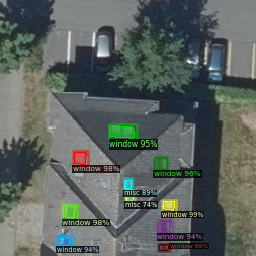

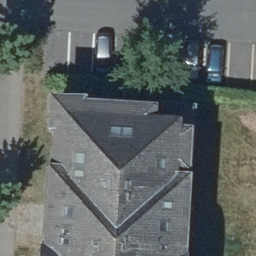

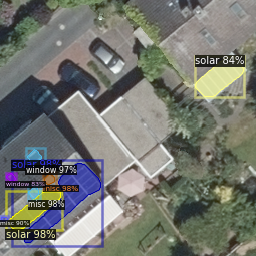

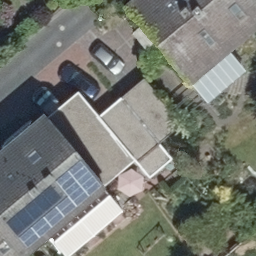

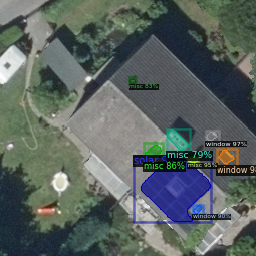

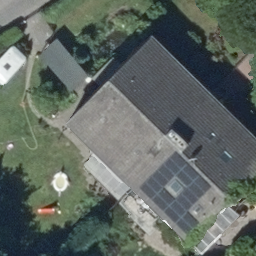

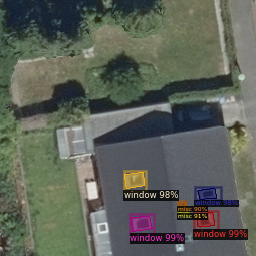

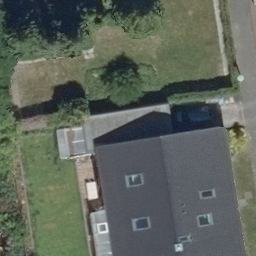

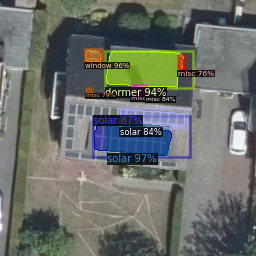

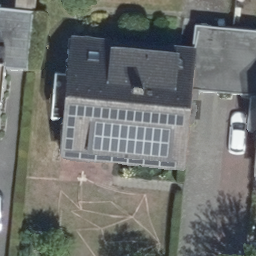

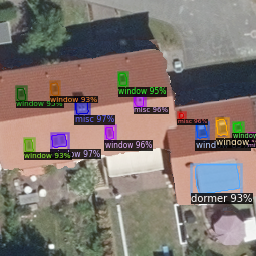

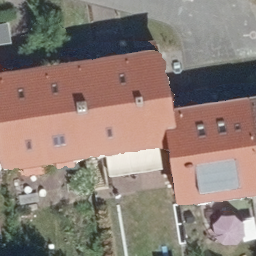

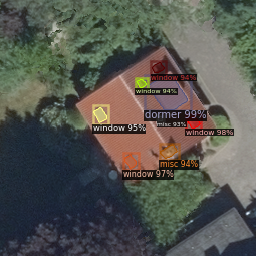

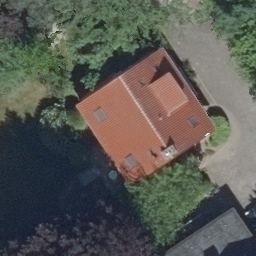

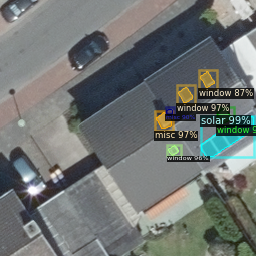

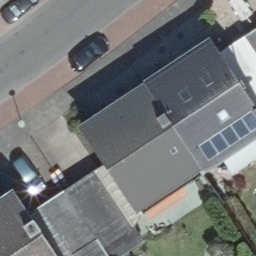

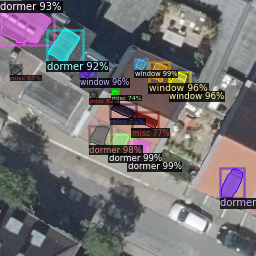

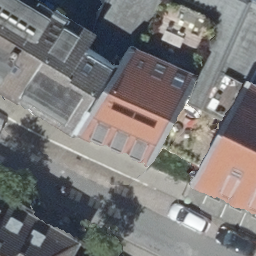

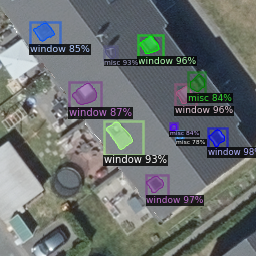

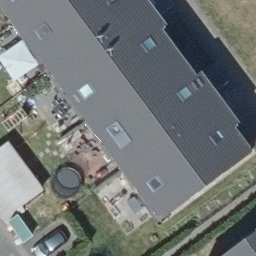

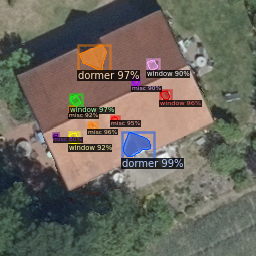

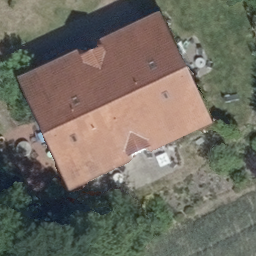

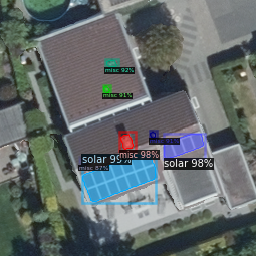

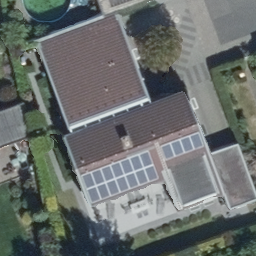

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts_test_only_solar, 12):    #dataset_dicts_test_only_solar, dataset_dicts_test
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=solar_houses_metadata, 
                   scale=1, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    cv2_imshow(im)

## Test on new images


These are now images, the model has never seen before

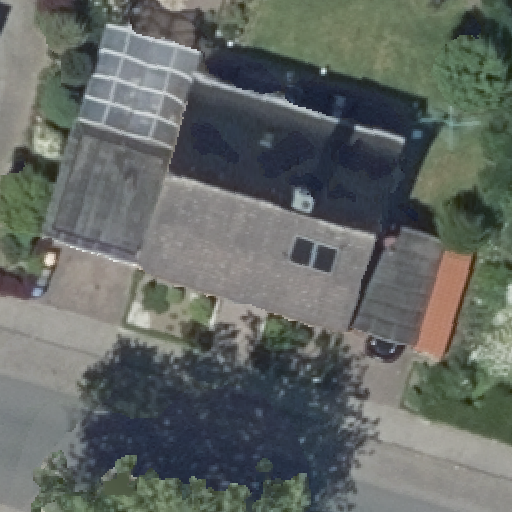

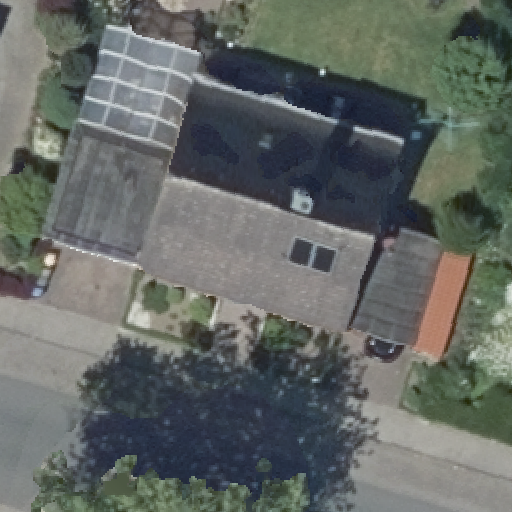

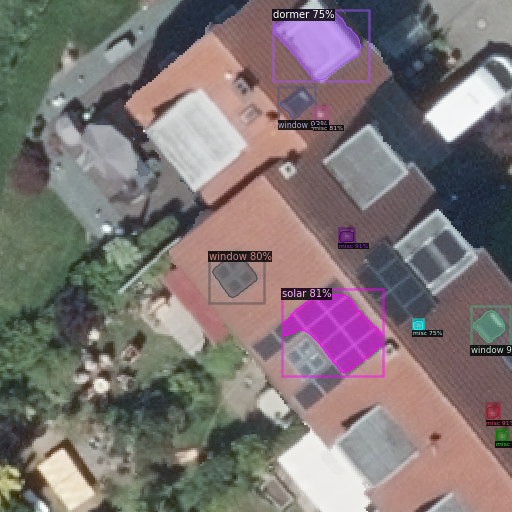

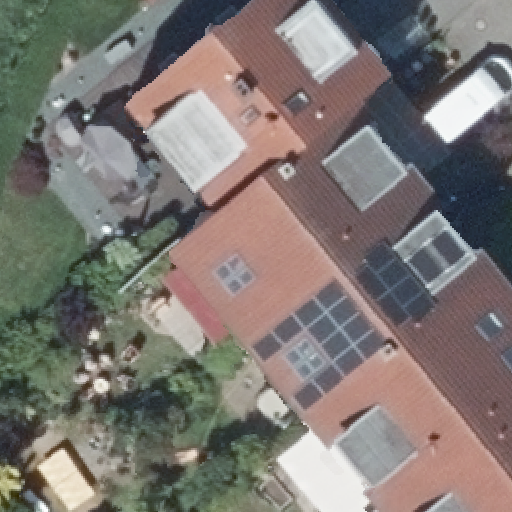

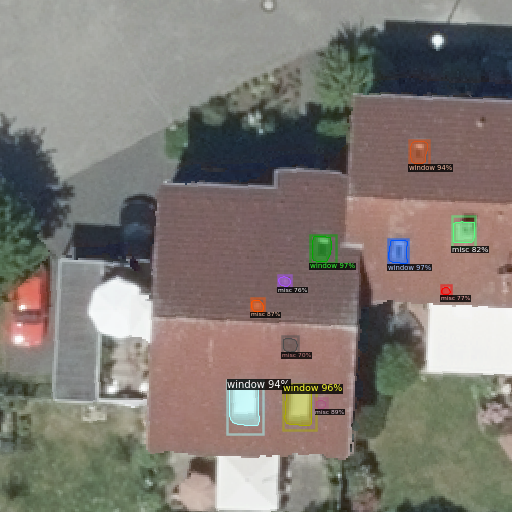

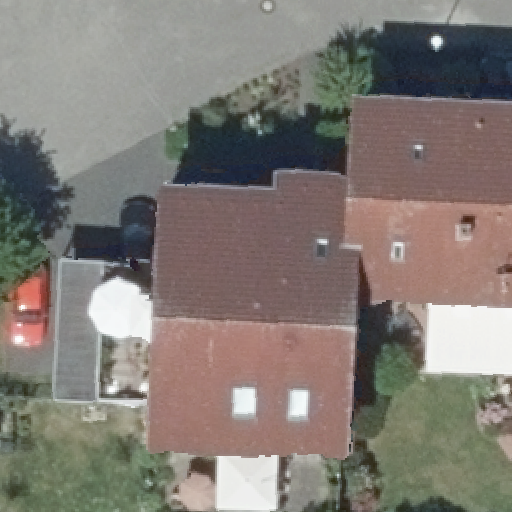

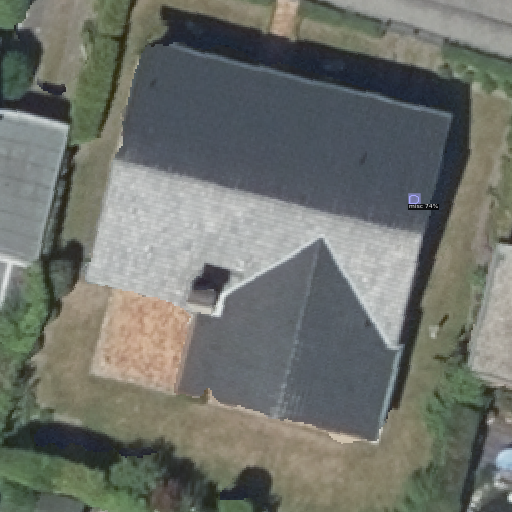

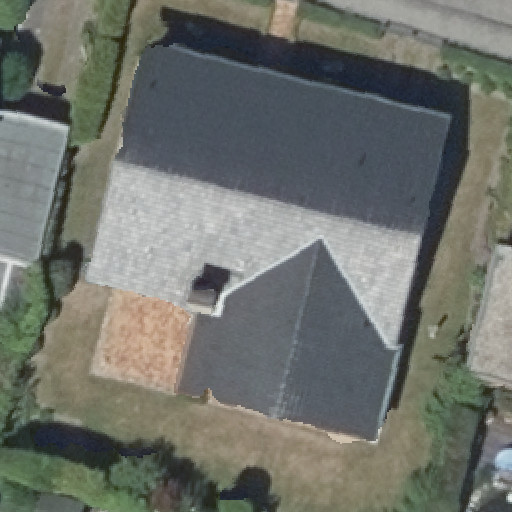

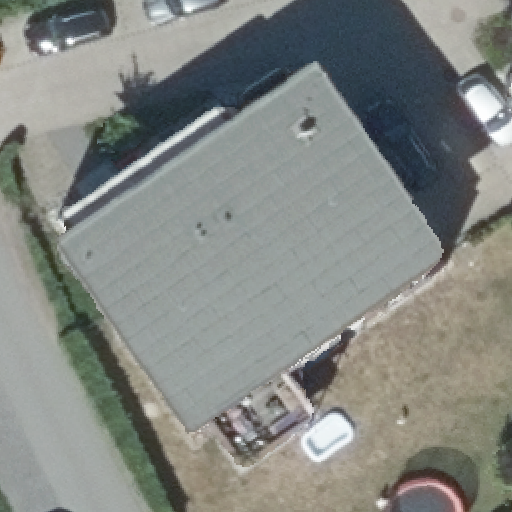

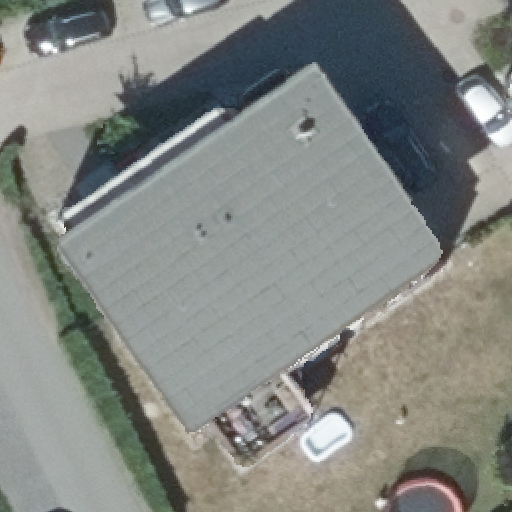

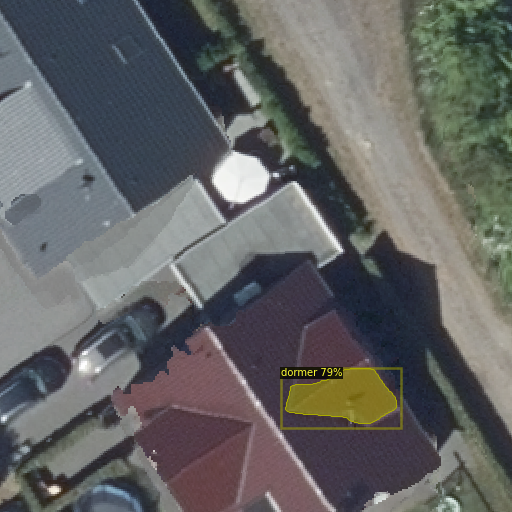

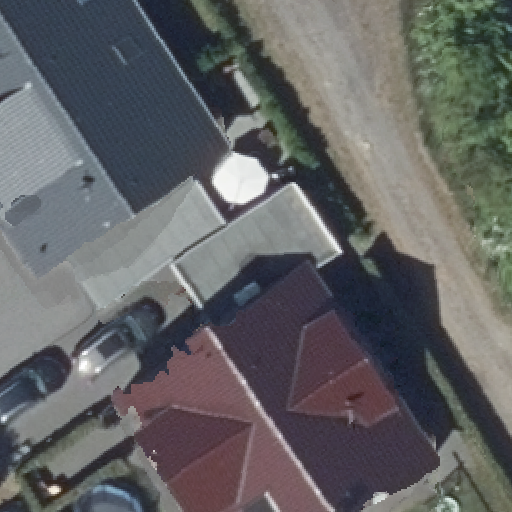

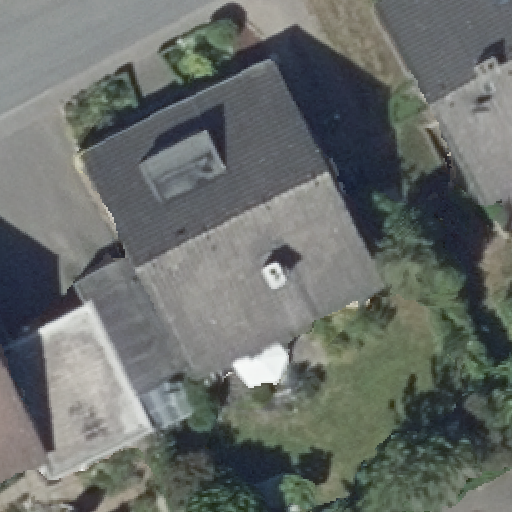

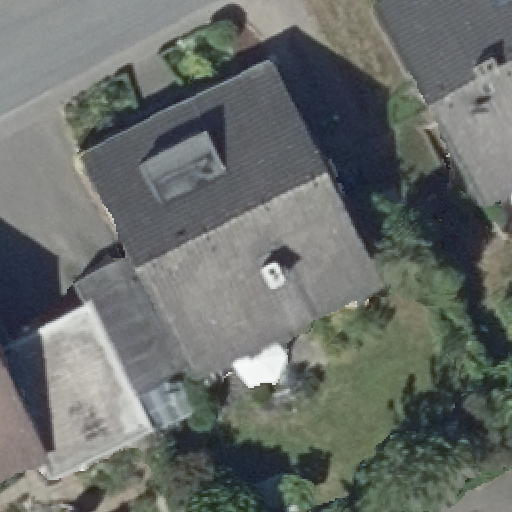

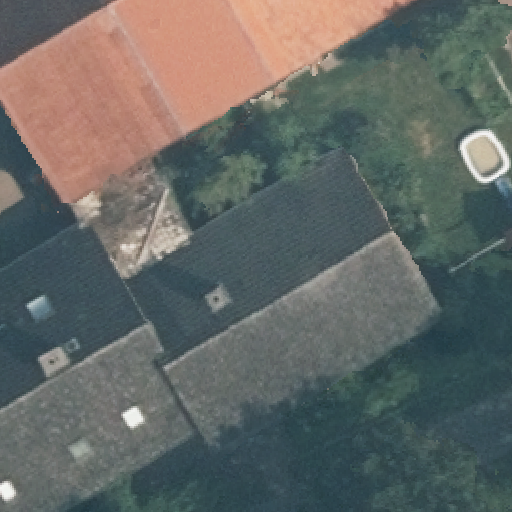

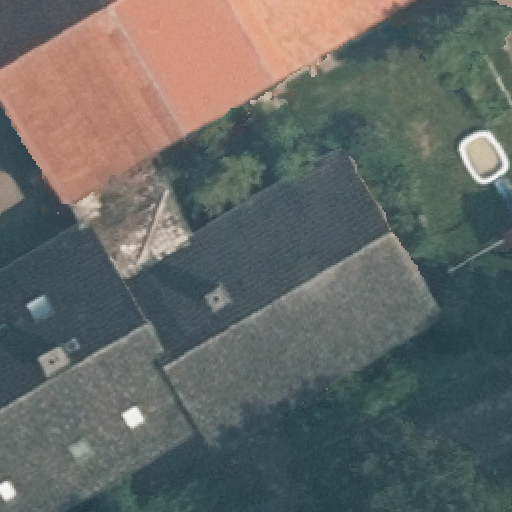

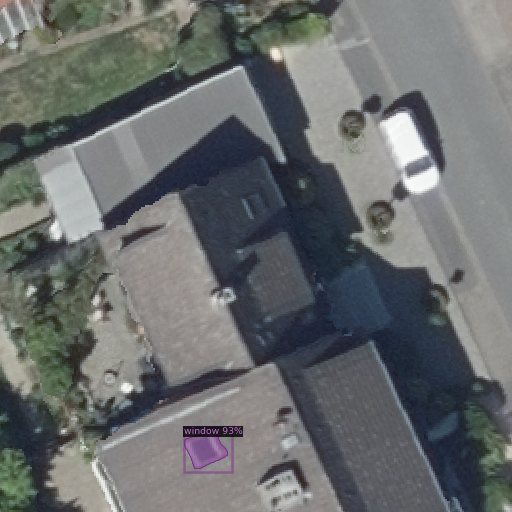

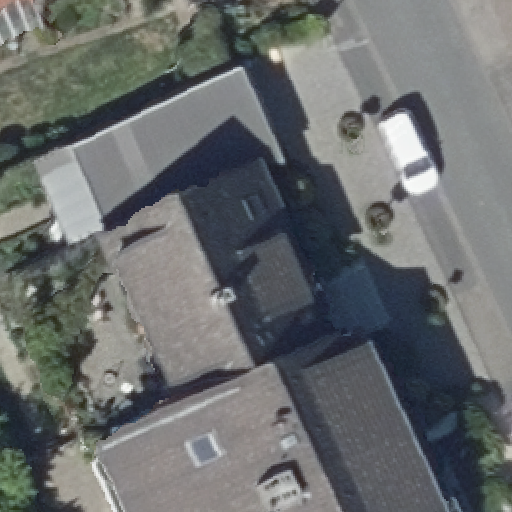

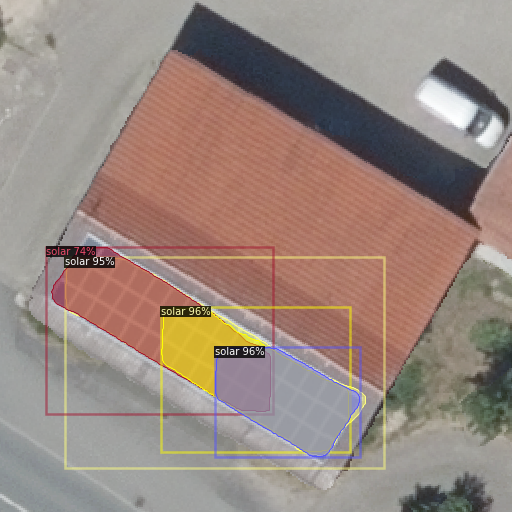

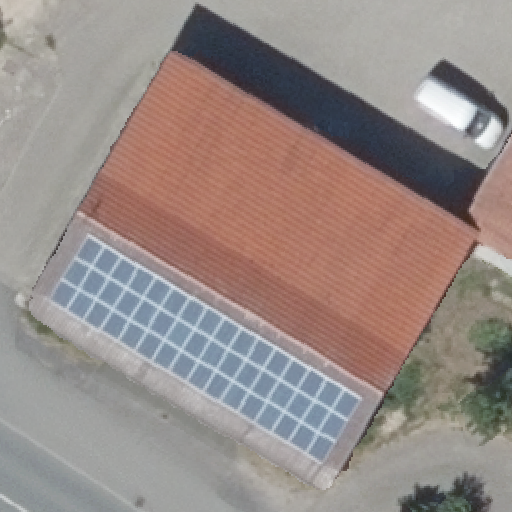

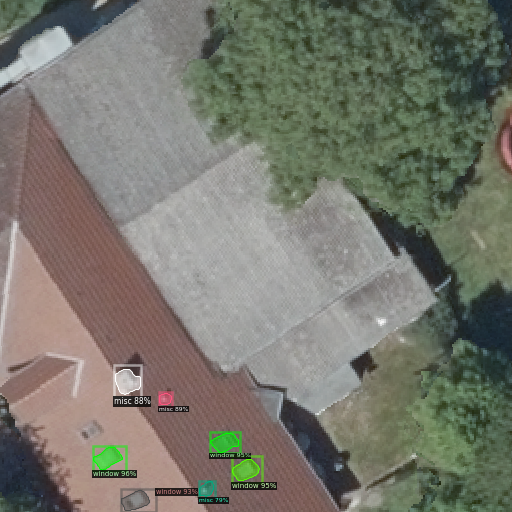

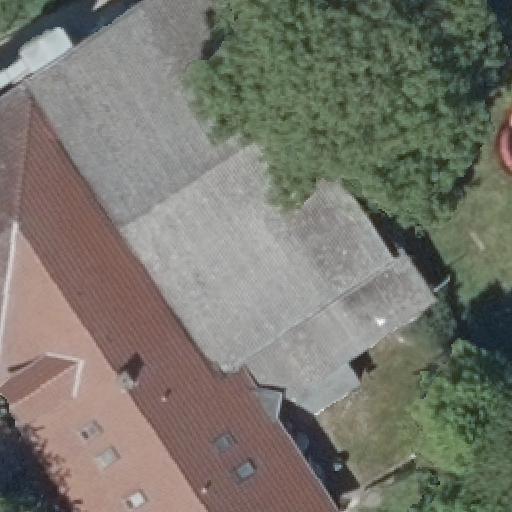

In [ ]:
# you can find the solar_images_test in the github:
#https://github.com/MagMueller/Solar-Potential-Analysis-using-Semi-Supervised-Image-Segmentation


test_path =  'drive/MyDrive/MSHACK_SoFiE_data/data/labeld_solar_images_test/'



for ind, d in enumerate(os.listdir(test_path)):    #dataset_dicts_test_only_solar, dataset_dicts_test
    #print(d)
    if ind > 10: break
    im = cv2.imread(test_path + d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=solar_houses_metadata, 
                   scale=1, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    cv2_imshow(im)



> Eingerückter Textblock

---





## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.29,fps:3.44
